# Practical Application Assignment 17.1: Comparing Classifiers to Predict Success of Marketing Campaign

## Data

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.feature_selection import RFE, SelectFromModel, SequentialFeatureSelector

import warnings
warnings.filterwarnings(action= 'ignore')

In [2]:
# data = pd.read_csv("data/bank-full.csv", sep= ";")
data = pd.read_csv("data/bank.csv", sep= ";") # import part dataset of exploratory data analysis
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [3]:
data['y'].value_counts(normalize= True)

y
no     0.88476
yes    0.11524
Name: proportion, dtype: float64

## Modeling

### Feature Transfrom

In [4]:
cat_features= ['job', 'marital', 'education', 'contact', 'poutcome', 'month']
binary_features = ['default', 'housing', 'loan']
num_features = np.setdiff1d(data.columns, np.union1d(cat_features, binary_features)).tolist()
num_features.remove('y')

target= 'y'
features = np.setdiff1d(data.columns, target).tolist()
data[target] = (data[target] == 'yes').astype(int)

data[binary_features] = (data[binary_features] == "yes").astype(int)
col_transform = ColumnTransformer([
    ('oe', OneHotEncoder(drop= 'if_binary'), cat_features),
    ('poly', PolynomialFeatures(degree= 1), num_features)], remainder = 'passthrough')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size= 0.3, stratify= data[target], random_state= 0)

### Logistic Regression

In [6]:
logreg_pipe = Pipeline([
    ('transform', col_transform),
    ('clf', LogisticRegression(penalty= 'l1', solver= 'liblinear'))
])

param_grid = {'clf__C': [1/(10**pp) for pp in range(-2,3)],
              'transform__poly__degree': range(1,3)}
logreg_grid = GridSearchCV(logreg_pipe, param_grid= param_grid, cv= 5, scoring= 'f1').fit(X_train, y_train)

y_pred_logreg = logreg_grid.predict(X_test)

print(logreg_grid.best_params_)
print("---------------------------------")

print(f"Training F1-score for Logistic Regression: {logreg_grid.score(X_train, y_train):0.2f}")
print(f"Test F1-score for Logistic Regression: {logreg_grid.score(X_test, y_test):0.2f}")

{'clf__C': 10.0, 'transform__poly__degree': 2}
---------------------------------
Training F1-score for Logistic Regression: 0.52
Test F1-score for Logistic Regression: 0.43


### K-Nearest Neighbors

In [12]:
knn_pipe = Pipeline([
    ('transform', col_transform),
    ('scale', StandardScaler()),
    ('clf', KNeighborsClassifier())
])

param_grid = {'clf__n_neighbors': [3,5,10,20,50,100,200], 'clf__metric': ['minkowski', 'cosine'], 'clf__weights': ['uniform', 'distance'], 
              'transform__poly__degree': range(1,3)}
knn_grid = GridSearchCV(knn_pipe, param_grid= param_grid, cv= 5, scoring= 'f1').fit(X_train, y_train)

y_pred_knn = knn_grid.predict(X_test)

print(knn_grid.best_params_)
print("---------------------------------")

print(f"Training F1-score for KNN Classifier: {knn_grid.score(X_train, y_train):0.2f}")
print(f"Test F1-score for KNN Classifier: {knn_grid.score(X_test, y_test):0.2f}")

{'clf__metric': 'cosine', 'clf__n_neighbors': 5, 'clf__weights': 'distance', 'transform__poly__degree': 2}
---------------------------------
Training F1-score for KNN Classifier: 1.00
Test F1-score for KNN Classifier: 0.40


### Decision Tree Classifier

In [36]:
tree_pipe = Pipeline([
    ('transform', col_transform),
    ('clf', DecisionTreeClassifier(random_state=0, criterion= 'entropy'))
])

param_grid = {'clf__max_depth': range(2,11,2), 'clf__min_samples_split': [2, 0.005, 0.01, 0.05, 0.1],
              'clf__criterion': ['gini', 'entropy'],
              'clf__class_weight': [None, 'balanced'],
              'transform__poly__degree': range(1,3)}
tree_grid = GridSearchCV(tree_pipe, param_grid= param_grid, cv= 5, scoring= 'f1').fit(X_train, y_train)

y_pred_tree = tree_grid.predict(X_test)

print(tree_grid.best_params_)
print("---------------------------------")

print(f"Training F1-score for Tree Classifier: {tree_grid.score(X_train, y_train):0.2f}")
print(f"Test F1-score for Tree Classifier: {tree_grid.score(X_test, y_test):0.2f}")

{'clf__class_weight': None, 'clf__criterion': 'entropy', 'clf__max_depth': 8, 'clf__min_samples_split': 0.01, 'transform__poly__degree': 1}
---------------------------------
Training F1-score for Tree Classifier: 0.62
Test F1-score for Tree Classifier: 0.50


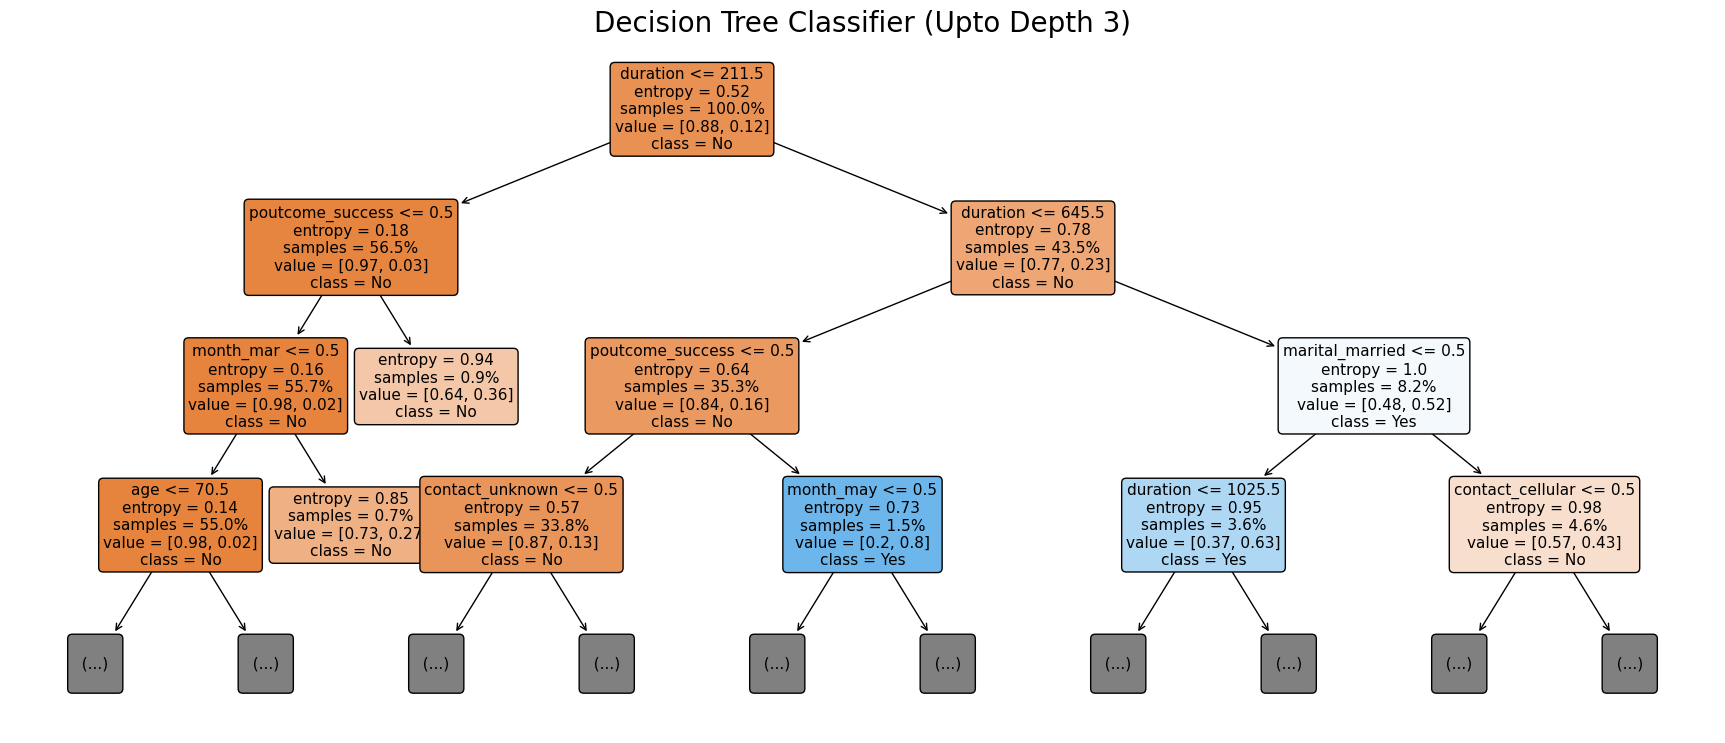

In [55]:
feature_names = tree_grid.best_estimator_[:-1].get_feature_names_out()
feature_names = [ss.replace('poly__','').replace('oe__','') for ss in feature_names]
plt.figure(figsize= (22,9))
plot_tree(tree_grid.best_estimator_[-1], feature_names= feature_names, rounded= True, class_names= ['No', 'Yes'],
           filled= True, max_depth= 3, fontsize= 11, precision= 2, proportion= True);
plt.title("Decision Tree Classifier (Upto Depth 3)", fontsize= 20);

### Support Vector Machine

In [9]:
svm_pipe = Pipeline([
    ('transform', col_transform),
    ('selector', RFE(LogisticRegression(), n_features_to_select= 42)),
    # ('clf', BaggingClassifier(estimator=SVC(), max_samples= 1000, n_estimators= 10))
    ('clf', SVC())
])

param_grid = {'clf__kernel': ['linear', 'rbf', 'sigmoid']}
svm_grid = GridSearchCV(svm_pipe, param_grid= param_grid, cv= 5, scoring= 'f1').fit(X_train, y_train)

y_pred_svm = svm_grid.predict(X_test)

print(svm_grid.best_params_)
print("---------------------------------")

print(f"Training F1-score for SVM: {svm_grid.score(X_train, y_train):0.2f}")
print(f"Test F1-score for SVM: {svm_grid.score(X_test, y_test):0.2f}")

{'clf__kernel': 'linear'}
---------------------------------
Training F1-score for SVM: 0.25
Test F1-score for SVM: 0.28


Text(0.5, 0.98, 'Compare ROC Curves for Different Classifiers')

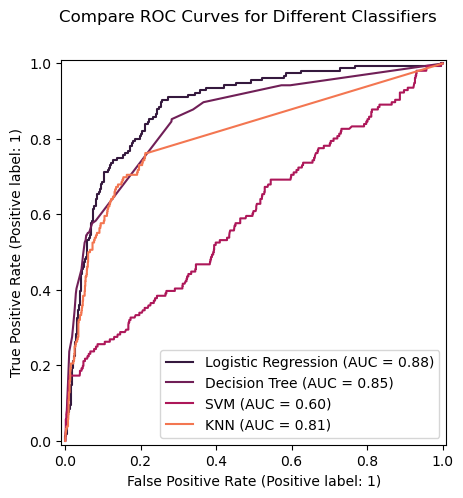

In [18]:
colors = sns.color_palette('rocket')

fig,ax = plt.subplots(figsize= (5,5))
RocCurveDisplay.from_estimator(logreg_grid, X_test, y_test, name= "Logistic Regression", ax= ax, color= colors[0])
RocCurveDisplay.from_estimator(tree_grid, X_test, y_test, name= "Decision Tree", ax= ax, color= colors[1])
RocCurveDisplay.from_estimator(svm_grid, X_test, y_test, name= "SVM", ax= ax, color= colors[2])
RocCurveDisplay.from_estimator(knn_grid, X_test, y_test, name= "KNN", ax= ax, color= colors[4])


plt.suptitle("Compare ROC Curves for Different Classifiers")

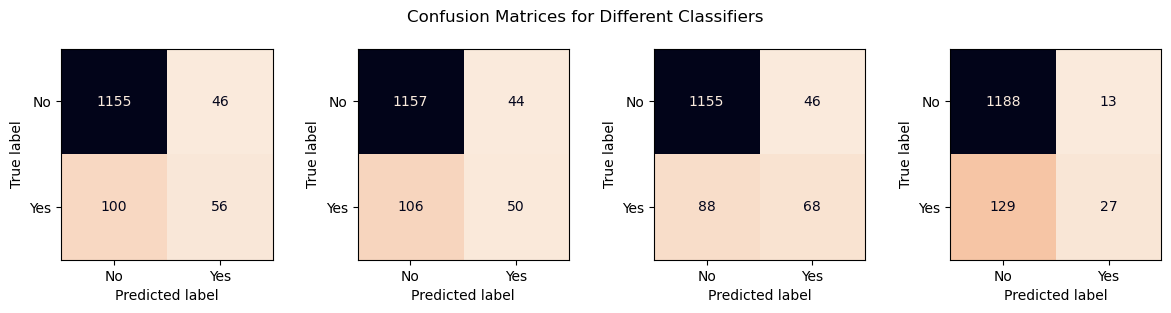

In [14]:
fig, axs = plt.subplots(figsize= (12,3), ncols= 4)

ConfusionMatrixDisplay.from_estimator(logreg_grid, X_test, y_test, ax= axs[0], cmap= sns.color_palette('rocket_r', as_cmap= True),
                                      display_labels= ['No','Yes'], colorbar= False)
ConfusionMatrixDisplay.from_estimator(knn_grid, X_test, y_test, ax= axs[1], cmap= sns.color_palette('rocket_r', as_cmap= True),
                                      display_labels= ['No','Yes'], colorbar= False)
ConfusionMatrixDisplay.from_estimator(tree_grid, X_test, y_test, ax= axs[2], cmap= sns.color_palette('rocket_r', as_cmap= True),
                                      display_labels= ['No','Yes'], colorbar= False)
ConfusionMatrixDisplay.from_estimator(svm_grid, X_test, y_test, ax= axs[3], cmap= sns.color_palette('rocket_r', as_cmap= True),
                                      display_labels= ['No','Yes'], colorbar= False)

plt.suptitle("Confusion Matrices for Different Classifiers")
plt.tight_layout();